In [ ]:
import matplotlib.pyplot as plt, numpy as np, scipy.stats as stats
from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import minimize

plt.style.use('mplstyle.txt')
%config InlineBackend.figure_format = 'retina'

In [2]:
hdul = fits.open('data/SMC_SNR/b0886.norm.dc.fits')
flux = hdul[0].data
if 'CD1_1' in list(hdul[0].header.keys()):
    wave = hdul[0].header['CRVAL1'] + hdul[0].header['CD1_1'] * (np.arange(hdul[0].header['NAXIS1']) - hdul[0].header['CRPIX1'] + 1)
else: wave = hdul[0].header['CRVAL1'] + hdul[0].header['CDELT1'] * (np.arange(hdul[0].header['NAXIS1']) - hdul[0].header['CRPIX1'] + 1)

hdul = fits.open('data/SMC_SNR/b0886_var.norm.dc.fits')
noise = np.sqrt(hdul[0].data)  # noise is the sqrt of the variance

In [3]:
# function to make the resulting fitted spectrum
def gaussians(x, params):
    y = np.zeros_like(x)  # initialize line
    if len(params) == 0:  # handle empty params (where there are no peaks)
        return y  # if there are no gaussians, just return the continuum
    for i in range(0, len(params), 3):
        amp, mean, std = params[i], params[i+1], params[i+2]  # params variable contains [amplitude, mean, stddev] of the gaussians
        y += amp * np.exp(-0.5 * ((x - mean) / std) ** 2)  # add a gaussian with the above parameters to the line
    return y

# function to be minimized
def negloglikelihood(params, x, y, errors):
    model = gaussians(x, params)  # create the multi-gaussian line
    residuals = y - model
    return 0.5 * np.sum((residuals / errors) ** 2) + np.sum(np.log(np.sqrt(2 * np.pi) * errors))

# calculate AIC and BIC
def info_crit(params, y, errors):
    n, k = len(y), len(params)  # number of data points and parameters
    aic = 2 * k + 2 * negloglikelihood(params, wave, y, errors)  # AIC = 2k - 2*log(L)
    bic = k * np.log(n) + 2 * negloglikelihood(params, wave, y, errors)  # BIC = k*log(n) - 2*log(L)
    return aic, bic

In [4]:
def gaussfit(spectrum, noise, analysis=False, crit='bic'):

    spectrum -= np.median(spectrum)
    smooth = savgol_filter(spectrum, window_length=11, polyorder=2)
    
    peaks, properties = find_peaks(smooth, height=noise, prominence=0.5*noise,  # less strict criteria
                             width=np.mean(np.diff(wave)), distance=10)
    
    if len(peaks) == 0:  # for the fits where no gaussians are fitted
        class nothing: x=np.array([]); aic=np.inf; bic=np.inf
        return nothing()
    
    sort_idx = np.argsort(properties['prominences'])[::-1]  # sort by descending prominence
    peaks, widths = peaks[sort_idx], properties['widths'][sort_idx]
    sigmas = np.diff(wave)[0] * widths / (2*(2*np.log(2))**0.5)  # stddev = FWHM / 2*sqrt(2*ln(2))
    
    models, aics, bics = [], [], []  # store results for different models
    
    # always run the null model
    null_aic, null_bic = info_crit(np.array([]), spectrum, noise)
    models.append((np.array([]), null_aic, null_bic))
    aics.append(null_aic); bics.append(null_bic)
    
    # run models with increasing number of peaks
    for n in range(1, min(len(peaks), 15) + 1):  # setting max peaks to 15
        init, bounds = [], []
        for p, sig in zip(peaks[:n], sigmas[:n]):
            amp, mean = spectrum[p], wave[p]
            init.extend([amp, mean, sig])  # initial guesses
            bounds.extend(([0, np.inf], [mean-2.5, mean+2.5], [0, np.inf]))
        
        result = minimize(negloglikelihood, init, args=(wave, spectrum, noise),
                         bounds=bounds, options={'maxiter': 2000})
        aic, bic = info_crit(result.x, spectrum, noise)
        models.append((result.x, aic, bic))
        aics.append(aic); bics.append(bic)
    
    # select best
    best_idx = np.nanargmin(bics if crit == 'bic' else aics)
    best = type('Result', (), {
        'x': models[best_idx][0], 'aic': models[best_idx][1],
        'bic': models[best_idx][2], 'all_aic': aics, 'all_bic': bics
    })()
    
    if analysis:
        fit = gaussians(wave, best.x)
        chisq = np.sum(((spectrum-fit)/noise)**2) / (len(spectrum)-len(best.x))
        mask = fit > 7
        statistic , pval = stats.ks_2samp(spectrum[mask], fit[mask]) if mask.any() else (np.nan, np.nan)
        return best, chisq, pval
    
    return best

/var/folders/s4/tddv5hsj2hz5y6yvpjzy963m0000gn/T/ipykernel_8969/1231118603.py:8: RuntimeWarning: divide by zero encountered in divide
  y += amp * np.exp(-0.5 * ((x - mean) / std) ** 2)  # add a gaussian with the above parameters to the line


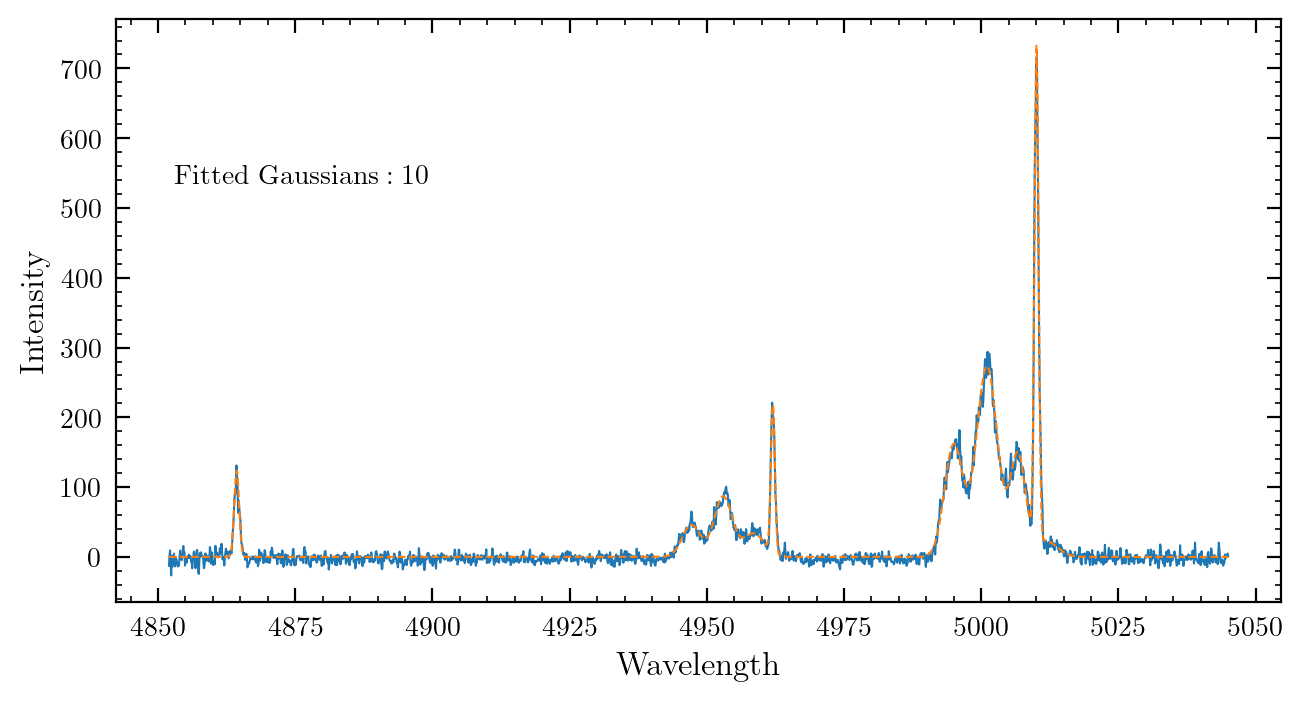

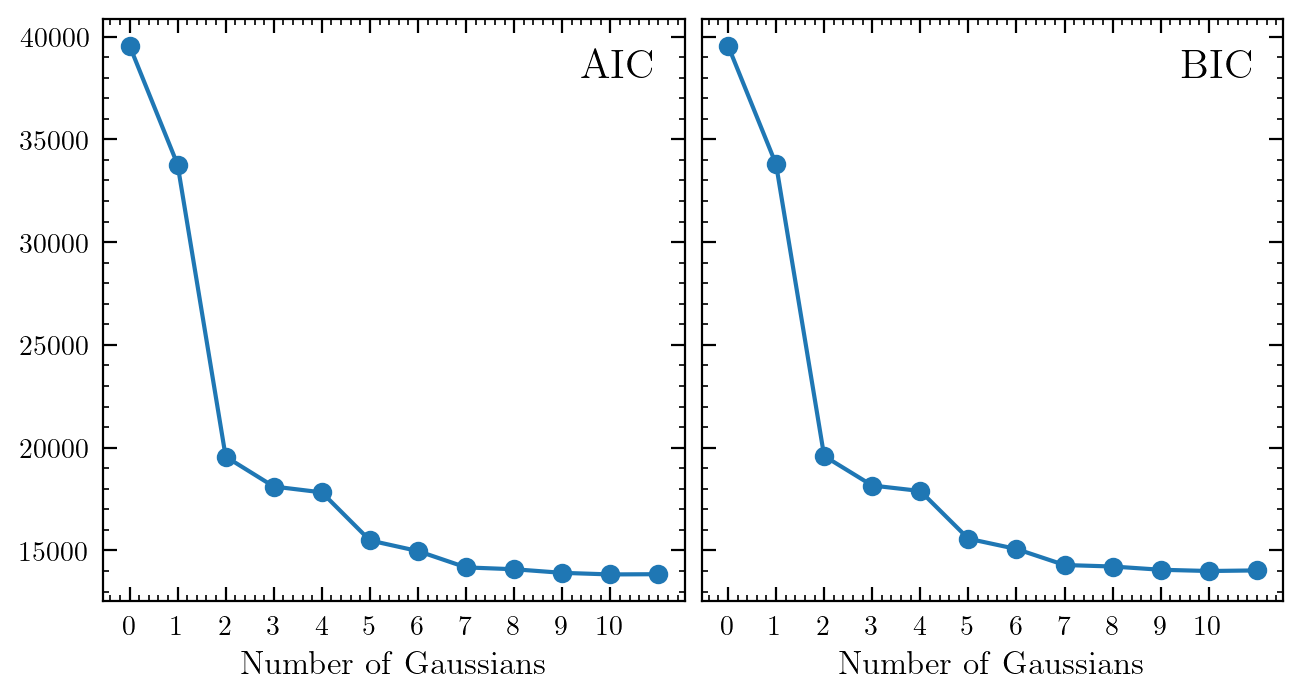

In [5]:
n = 110
model = gaussfit(flux[n], noise[n])

fig, ax = plt.subplots(1,1, layout='compressed')

ax.plot(wave, flux[n]-np.median(flux[n]), lw=0.75, label=r'$\mathrm{Spectrum}$')
ax.plot(wave, gaussians(wave, model.x), lw=0.75, label=r'$\mathrm{Multi\ Gaussian\ Fit}$', ls='dashed')
ax.set_ylabel(r'$\rm Intensity$'); ax.set_xlabel(r'$\rm Wavelength$')
ax.text(0.05, 0.75, rf'$\rm Fitted\ Gaussians: {len(model.x)//3}$', ha='left', va='top', transform=ax.transAxes)
ax.set_box_aspect(0.5)

fig, ax = plt.subplots(1,2, layout='compressed', sharey=True)

ax[0].plot(range(len(model.all_aic)), model.all_aic, marker='o')
ax[1].plot(range(len(model.all_bic)), model.all_bic, marker='o')
ax[0].set_xlabel(r'$\rm Number\ of\ Gaussians$'); ax[1].set_xlabel(r'$\rm Number\ of\ Gaussians$')
ax[0].text(0.95, 0.95, r'$\rm AIC$', ha='right', va='top', fontsize=15, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, r'$\rm BIC$', ha='right', va='top', fontsize=15, transform=ax[1].transAxes)
for a in ax: a.set_box_aspect(1); a.set_xticks(np.arange(0,np.max(range(len(model.all_aic))),1))

In [6]:
# calculate jacobian matrix
eps = 1e-8
jacobian = np.zeros((len(wave), len(model.x)))
for i in range(len(model.x)):
    params_plus=model.x.copy();  params_plus[i] += eps
    params_minus=model.x.copy(); params_minus[i] -= eps
    jacobian[:, i] = (gaussians(wave, params_plus) - gaussians(wave, params_minus)) / (2 * eps)

# calculate covariance matrix
weights = 1.0 / (noise[n] ** 2)  # for gaussian errors: W = diag(1/sigma^2)
covariance = np.linalg.inv(np.matmul(jacobian.T, (weights[:, None] * jacobian)))  # cov = (J^T * W * J)^(-1) where W is inv cov of data
uncertainties = np.sqrt(np.diag(covariance))  

In [7]:
print('    amplitude                 mean                   stddev \n')
for i in range(0, len(model.x), 3):
    amp, mean, std = model.x[i], model.x[i+1], model.x[i+2]
    damp, dmean, dstd = uncertainties[i], uncertainties[i+1], uncertainties[i+2]
    print(f'{amp:8.4f} +-{damp:8.4f}    {mean:8.4f} +-{dmean:8.4f}     {std:8.4f} +-{dstd:8.4f}')

    amplitude                 mean                   stddev 

710.8100 +- 12.9531    5010.0792 +-  0.0063       0.3729 +-  0.0071
272.9513 +-  4.1108    5001.0352 +-  0.0366       1.9133 +-  0.0516
212.5401 +-  7.4656    4962.0367 +-  0.0128       0.3656 +-  0.0136
124.0470 +-  8.4457    4864.3360 +-  0.0328       0.4435 +-  0.0318
 86.4139 +-  2.8501    4952.9721 +-  0.0886       1.6417 +-  0.1071
160.5914 +-  3.4183    4994.9825 +-  0.0535       1.6698 +-  0.0496
145.5096 +-  4.8343    5006.6557 +-  0.0783       1.4076 +-  0.0821
 45.8225 +-  2.5312    4947.1681 +-  0.1245       1.6585 +-  0.1294
 33.5534 +-  2.4249    4958.5307 +-  0.2288       1.9239 +-  0.3060
 22.7155 +-  3.0470    5011.7525 +-  0.8640       2.1056 +-  0.6338
